# Sentiment Analysis of Stock Twits with Multi Layer Perceptron

### Import libs

In [1]:
#### NLP LIBS ###
import nltk
import numpy as np
import pandas as pd

from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

### Import utils function ###
from utils import get_tweets_from_db, eval_model, URI, DB_NAME
from cleaning_utils import full_preprocess, get_grams

### Get Tweets from MongoDB database (`db_tweets.META`)

In [2]:
# Retrieve data from MongoDB
data_from_mongodb = get_tweets_from_db(uri=URI, db_name=DB_NAME, collection_name="AAPL")

# Create DataFrame from retrieved data
df_apple_tweets = pd.DataFrame(data_from_mongodb)

df_apple_tweets

,_id,date,content,true_sentiment
0,662691526f6491024e22dd9f,2024-04-22T16:30:04Z,$AAPL nice dip quickies $$$$$$$$$$$$$,None
1,662691536f6491024e22dda1,2024-04-22T16:27:30Z,$AAPL fucking sweatshops,bearish
2,662691536f6491024e22dda3,2024-04-22T16:26:43Z,$AAPL cnbc guy says sees another 5% down bit h...,None
3,662691546f6491024e22dda5,2024-04-22T16:26:06Z,$AAPL look for a move to the downside in the s...,bullish
4,662691556f6491024e22dda7,2024-04-22T16:24:16Z,Hey $AAPL $CMCSA &amp; $GOOG you can have my $...,None
...,...,...,...,...
137,662691d86f6491024e22deb1,2024-04-22T15:12:24Z,$AAPL 140,bearish
138,662691d86f6491024e22deb3,2024-04-22T15:12:07Z,$AAPL Y&#39;all were supposed to sell at 200. ...,bullish
139,662691e26f6491024e22deb5,2024-04-22T16:30:04Z,$AAPL nice dip quickies $$$$$$$$$$$$$,None
140,662691e46f6491024e22deb7,2024-04-22T16:27:30Z,$AAPL fucking sweatshops,bearish


## Data preprocessing

- Replace the hashtags
- Remove stopwords and useless punctuation
- Keep the following punctuation: `'! ? % + - = : ; ) ( ]'`
- Include emoji

In [2]:
df_apple_tweets = pd.read_parquet('balanced_250k.parquet')
df_apple_tweets['cleaned_content'] = df_apple_tweets['content_cleaned']
df_apple_tweets

,date,content,true_sentiment,content_cleaned,cleaned_content
139036,2017-05-09T20:32:06Z,$AAPL I wanna sell some shares to buy me an #a...,1.0,cashtag I wanna sell some shares to buy me an...,cashtag I wanna sell some shares to buy me an...
981796,2023-02-08T21:31:58Z,"$HOOD Don't forget $AAPL tomorrow, headed to 157+",1.0,"cashtag Don't forget cashtag tomorrow, heade...","cashtag Don't forget cashtag tomorrow, heade..."
359413,2022-05-13T08:55:11Z,$AAPL Another fake upside move… \nTake profi...,0.0,cashtag Another fake upside move… \nTake pr...,cashtag Another fake upside move… \nTake pr...
2199286,2019-09-18T06:02:46Z,$AAPL iPhone 11 preorder goes well in China,1.0,cashtag iPhone 11 preorder goes well in China,cashtag iPhone 11 preorder goes well in China
225978,2023-06-05T13:57:33Z,$SPY $AAPL Headlines and clickbait articles li...,0.0,cashtag cashtag Headlines and clickbait arti...,cashtag cashtag Headlines and clickbait arti...
...,...,...,...,...,...
1353599,2019-08-13T19:38:54Z,$TRNX damm pls $AAPL pls $MSFT pls $NFLX take ...,1.0,cashtag damm pls cashtag pls cashtag pls ca...,cashtag damm pls cashtag pls cashtag pls ca...
1502926,2013-03-12T18:39:41Z,$AAPL IDC Jan 31 2013 &quot;iPad accounted for...,1.0,cashtag IDC Jan 31 2013 &quot;iPad accounted ...,cashtag IDC Jan 31 2013 &quot;iPad accounted ...
1767016,2021-09-02T14:25:34Z,$AAPL bears are silly!,1.0,cashtag bears are silly!,cashtag bears are silly!
1801456,2023-11-02T19:59:27Z,$AAPL just sold the iPhone I just bought for d...,0.0,cashtag just sold the iPhone I just bought fo...,cashtag just sold the iPhone I just bought fo...


In [3]:

# Select features
X = df_apple_tweets["cleaned_content"]

# Select the labels
y = df_apple_tweets['true_sentiment']

### Building Bag of Words (BoW)

To do so, we convert text data into numerical features using `CountVectorizer`

We use *unigram* and *bigram* as text features so we set the parameter `ngram_range=(2,2)`

We set the parameter `min_df` because we want to impose a minimum word frequency of 0.0001% (or 25 occurrences) to remove very infrequent words and reduce computation time for GridSearchCV

Hence, when building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature

In [4]:
# Convert text data into numerical feature
X_vectorized = CountVectorizer(ngram_range=(1, 2), min_df=25).fit_transform(X)
X_vectorized

<250000x23260 sparse matrix of type '<class 'numpy.int64'>'
	with 5046344 stored elements in Compressed Sparse Row format>

## Train test split data

In [5]:
# Split the dataframe
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

### Initialize the MLP

In [6]:
mlp_classifier = MLPClassifier(random_state=42, max_iter=20, learning_rate_init=0.01, tol=0.001, early_stopping=True, n_iter_no_change=4)

#### Define the hyperameters for the grid search CV

In [7]:
# Define hyperparameters grid
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,)],
    'activation': ['logistic'],
    'solver': ['adam'],
}

### Apply the grid search CV

In [8]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=mlp_classifier, param_grid=param_grid, cv=3, scoring='accuracy')


# Perform GridSearchCV
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=MLPClassifier(early_stopping=True,
                                     learning_rate_init=0.01, max_iter=20,
                                     n_iter_no_change=4, random_state=42,
                                     tol=0.001),
             param_grid={'activation': ['logistic'],
                         'hidden_layer_sizes': [(50,), (100,), (150,)],
                         'solver': ['adam']},
             scoring='accuracy')

### Get the best parameters and best score

In [9]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'activation': 'logistic', 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Best Score: 0.7587149862378669


### Get the predictions (forward path)

In [10]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#### Visualize the predictions

In [13]:
y_pred

array(['bullish', 'bearish', 'bearish', 'bullish', 'bullish', 'bullish',
       'bullish', 'bullish', 'bullish', 'bullish', 'bullish', 'bullish',
       'bullish'], dtype='<U7')

### Model Evaluation

To evaluate the model performance prediction we compute the confusion matrix and the classification report

######## Classification Report ########

              precision    recall  f1-score   support

         0.0       0.78      0.76      0.77     25009
         1.0       0.76      0.79      0.78     24991

    accuracy                           0.77     50000
   macro avg       0.77      0.77      0.77     50000
weighted avg       0.77      0.77      0.77     50000

######## Accuracy Score ########
0.77



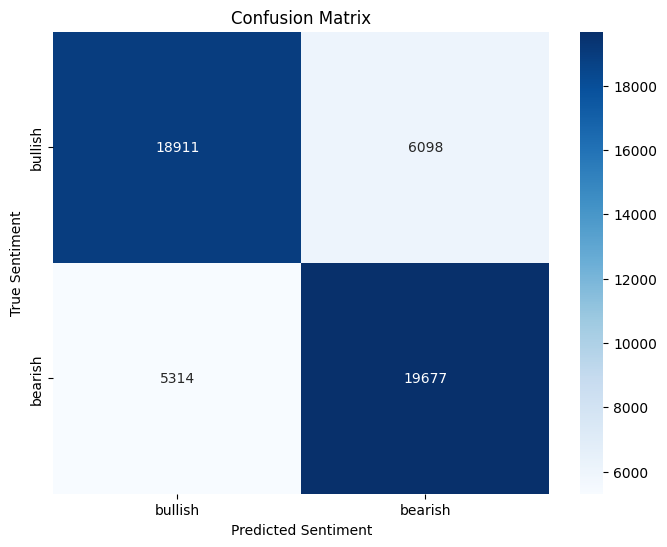

In [11]:
eval_model(pd.DataFrame(y_test), pd.DataFrame(y_pred))